# Описание проекта

Анализ для крупного интернет-магазина. Вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки.

*Общие задачи:*
- Приоритизировать гипотезы
- Запустить A/B-тест
- Проанализировать результаты

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
hypothesis = pd.read_csv('datasets/hypothesis.csv', index_col=0)
orders = pd.read_csv('datasets/orders.csv', index_col=0)
visitors = pd.read_csv('datasets/visitors.csv', index_col=0)

## Содержание <a class='anchor' id='up'></a>

[**Часть 1. Приоритизация гипотез**](#1)

- [1.1 Фреймворк ICE](#11)

- [1.2 Фреймворк RICE](#12)

- [1.3 Изменение приоритизации при применении RICE вместо ICE](#13)

[**Часть 2. Анализ A/B-теста**](#2)

- [2.1 График кумулятивной выручки по группам](#21)

- [2.2 График кумулятивного среднего чека по группам](#22)

- [2.3 График относительного изменения кумулятивного среднего чека группы B к группе A](#23)

- [2.4 График кумулятивной конверсии по группам](#24)

- [2.5 График относительного изменения кумулятивной конверсии группы B к группе A](#25)

- [2.6 Точечный график количества заказов по пользователям](#26)

- [2.7 95-й и 99-й перцентили количества заказов на пользователя](#27)

- [2.8 Точечный график стоимостей заказов](#28)

- [2.9 95-й и 99-й перцентили стоимости заказов](#29)

- [2.10 Статистическая значимость различий в конверсии между группами по «сырым» данным](#210)

- [2.11 Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#211)

- [2.12 Статистическая значимость различий в конверсии между группами по «очищенным» данным](#212)

- [2.13 Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#213)

- [2.14 Решение по результатам теста](#214)

[ЗАКЛЮЧЕНИЕ](#total)

# Часть 1. Приоритизация гипотез <a class='anchor' id='1'></a>

Подготовим данные:

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 432.0+ bytes


Приведем названия к нижнему регистру:

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

Увеличим максимальное количество знаков к колонке (чтобы видеть гипотезы полностью):

In [5]:
pd.options.display.max_colwidth=200

In [6]:
hypothesis.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


*Описание данных:*
- **hypothesis** — краткое описание гипотезы;
- **reach** — охват пользователей по 10-балльной шкале;
- **impact** — влияние на пользователей по 10-балльной шкале;
- **confidence** — уверенность в гипотезе по 10-балльной шкале;
- **efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение **Efforts**, тем дороже проверка гипотезы.

[⬆︎ К содержанию ⬆︎](#up)

Проверим, являются ли баллы в пределах значений от 1 до 10: <a class='anchor' id='edit1'></a>

In [7]:
check = []
for x in ['reach', 'impact', 'confidence', 'efforts']:
    for u in hypothesis[x].unique():
        check.append(u in range(1,11))
if False not in check:
    print ('Аномальных значений не обнаружено')
else:
    print ('Аномальные значения присутствуют')

Аномальных значений не обнаружено


### 1.1 Фреймворк ICE <a class='anchor' id='11'></a>

Рассчитаем фреймворк:

In [8]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

Выведем результаты:

In [9]:
hypothesis.loc[:,['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


[⬆︎ К содержанию ⬆︎](#up)

### 1.2 Фреймворк RICE <a class='anchor' id='12'></a>

Рассчитаем фреймворк:

In [10]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

Выведем результаты:

In [11]:
hypothesis.loc[:,['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


[⬆︎ К содержанию ⬆︎](#up)

### 1.3 Изменение приоритизации при применении RICE вместо ICE <a class='anchor' id='13'></a>

Рассмотрим все оценки гипотез-победителей:

In [12]:
hypothesis.loc[[8,7]].sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2


###### Фреймворк ICE не учитывает параметр Reach(оценка охвата пользователей), а значит во время применения RICE у любой гипотезы с оценкой охвата больше 1 есть шанс изменить рейтинг.

В нашем случае так и произошло - гипотеза с идексом №7 получила максимальную оценку охвата. Но, не смотря на то, что по оценке impact(влияние на пользователей) она проиграла 2 бала и по оценке confidence(уверенность в гипотезе) 1 балл - гипотеза №7 выбивается в абсолютные лидеры. Efforts (затраты) по оценкам одинаковые, так что с коммерческой точки зрения, вероятно эти гипотезы идентичны.

[⬆︎ К содержанию ⬆︎](#up)

# Часть 2. Анализ A/B-теста <a class='anchor' id='2'></a>

Подготовим данные:

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 56.1+ KB


In [14]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [15]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


*Описание данных:*
- **transaction_id** — идентификатор заказа;
- **visitor_id** — идентификатор пользователя, совершившего заказ;
- **date** — дата, когда был совершён заказ;
- **revenue** — выручка заказа;
- **group** — группа A/B-теста, в которую попал заказ.

---

In [16]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ KB


In [17]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


*Описание данных:*
- **date** — дата;
- **group** — группа A/B-теста;
- **visitors** — количество пользователей в указанную дату в указанной группе A/B-теста

---

##### Проверка корректности и целостности данных: <a class='anchor' id='edit2'></a>

Несоответсвие данных приложенному описанию: данные соответствую описанию (названия полей приведены к единому формату)

Наличие дубликатов и анализ соответствия данных описанию:

##### orders:

In [18]:
orders.duplicated().sum()

0

In [19]:
len(orders)

1197

In [20]:
orders.nunique()

transaction_id    1197
visitor_id        1031
date                31
revenue            713
group                2
dtype: int64

В таблице orders полные дубликаты отсутствуют. Длина датафрейма соответствует количеству транзакций. В после group представлено две уникальных категории, как и ожидалось.

In [21]:
orders.sample(10)

,transaction_id,visitor_id,date,revenue,group
276,1634965106,281523083,2019-08-23,2290,A
471,798048333,3462462738,2019-08-03,2490,A
103,2951399376,2019355024,2019-08-01,2550,B
854,2865895399,1732269954,2019-08-27,760,A
943,1215018444,2406897935,2019-08-08,18350,B
212,1764119908,3332057097,2019-08-02,2820,B
13,3044797713,728063420,2019-08-15,11985,B
1153,2764584088,1562205279,2019-08-14,2955,B
1017,1729012139,3613900590,2019-08-31,13070,A
406,1441855393,1404934699,2019-08-03,26980,B


В случайной выборке все данные соответствуют представленному описанию.

In [22]:
print('Исследуемый период с', orders['date'].min(), 'по', orders['date'].max())

Исследуемый период с 2019-08-01 по 2019-08-31


Аномалии и проверка на логику:

In [23]:
orders['transaction_id'].unique()

array([3667963787, 2804400009, 2961555356, ..., 1807773912, 1947021204,
       3936777065])

In [24]:
orders['visitor_id'].unique()

array([3312258926, 3642806036, 4069496402, ...,  370388673,  573423106,
       2108080724])

In [25]:
orders['date'].describe()

count           1197
unique            31
top       2019-08-05
freq              48
Name: date, dtype: object

In [26]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

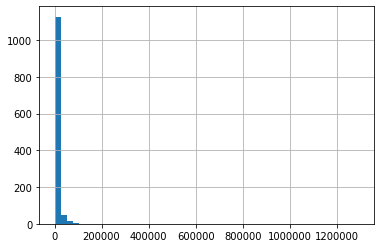

In [27]:
orders['revenue'].hist(bins=50);

Верхняя граница выбросов 15360 (Q3+1.5IQR). Гистограмма показывает что самые частые суммы покупов сосредоточились около 15000.

In [28]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

Других групп в тесте не представлено.

##### visitors:

In [29]:
visitors.duplicated().sum()

0

In [30]:
len(visitors)

62

In [31]:
visitors.nunique()

date        31
group        2
visitors    58
dtype: int64

В таблице visitors полные дубликаты так же отсутсвуют. Однако смутило что длина датафрема в 62 элемента не соттветсвует количеству уникальных посетителей).

In [32]:
visitors['date'].describe()

count             62
unique            31
top       2019-08-17
freq               2
Name: date, dtype: object

In [33]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

Представлены 2 уникальные группы, как и заявлено в условии.

In [34]:
visitors[visitors['visitors'].duplicated()]

,date,group,visitors
39,2019-08-09,B,610
58,2019-08-28,B,654
60,2019-08-30,B,490
61,2019-08-31,B,718


Эти 4 пользвователя посетили ресурс дважды. Но поскольку нас интересует количство пользователей на дату, а уникальность в данном случае не играет роли, то дубликаты мы удалять не будем.

[⬆︎ К содержанию ⬆︎](#up)

### 2.1 График кумулятивной выручки по группам <a class='anchor' id='21'></a>

Создадим массив уникальны пар дат и групп:

In [35]:
dates_groups = orders[['date','group']].drop_duplicates()
dates_groups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


Получим агрегированные кумулятивные по дням данные о заказах:

In [36]:
orders_aggregated = dates_groups.apply(
    lambda x: orders[(orders['date'] <= x['date']) & (orders['group'] == x['group'])].agg(
        {'date':'max', 'group':'max', 'transaction_id': 'nunique', 
         'visitor_id': 'nunique', 'revenue':'sum'}),
            axis=1).sort_values(by=['date', 'group'])
orders_aggregated

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


Получаем агрегированные кумулятивные по дням данные о посетителях:

In [37]:
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[(visitors['date'] <= x['date']) & (visitors['group'] == x['group'])].agg(
        {'date':'max', 'group':'max', 'visitors':'sum'}),axis=1).sort_values(by=['date', 'group'])
visitors_aggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


Объединим агрегированные кумулятивные по дням данные о посетителях:

In [38]:
cummulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date','group'])
cummulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cummulative_data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


Построим графики кумулятивной выручки по группам А и B:

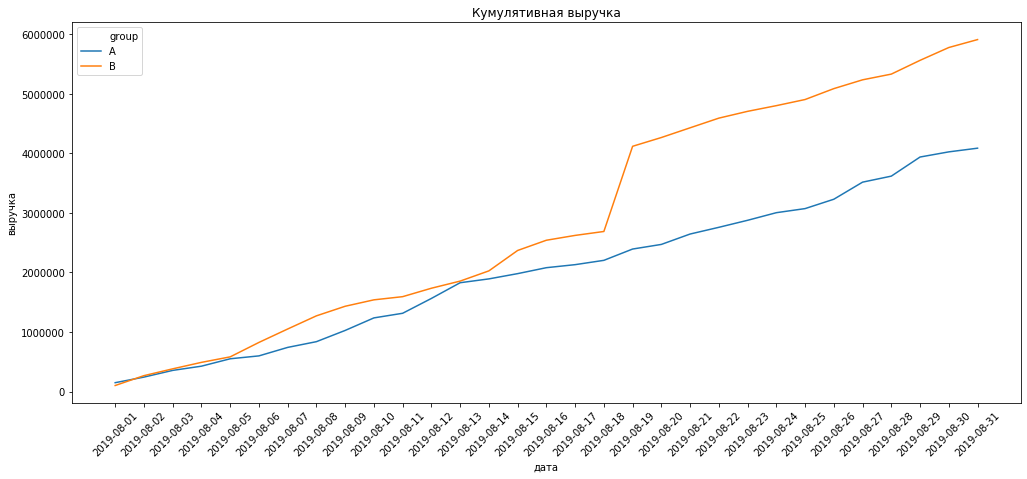

In [39]:
plt.figure(figsize=(17,7))
plt.title('Кумулятивная выручка')
sns.lineplot(x='date', y='revenue', hue='group', data=cummulative_data).set_xticklabels(
    cummulative_data['date'].drop_duplicates(),rotation=45)
plt.xlabel('дата')
plt.ylabel('выручка');

Выручка равномерно увеличивается до 18 августа, после чего группа B начинает приносить ощутимо более высокий доход. Либо это большое увеличение числа заказов, либо появление очень дорогих заказов.

[⬆︎ К содержанию ⬆︎](#up)

### 2.2 График кумулятивного среднего чека по группам <a class='anchor' id='22'></a>

Вычислим средний чек:

In [40]:
cummulative_data['avg_check'] = cummulative_data['revenue'] / cummulative_data['orders']
cummulative_data.head()

,date,group,orders,buyers,revenue,visitors,avg_check
0,2019-08-01,A,24,20,148579,719,6190.791667
1,2019-08-01,B,21,20,101217,713,4819.857143
2,2019-08-02,A,44,38,242401,1338,5509.113636
3,2019-08-02,B,45,43,266748,1294,5927.733333
4,2019-08-03,A,68,62,354874,1845,5218.735294


Построим графики среднего чека по группам:

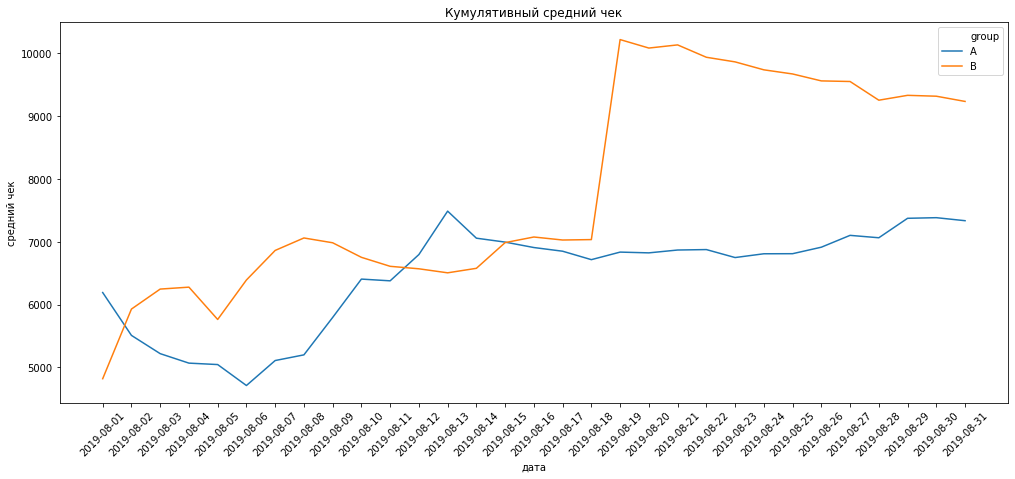

In [41]:
plt.figure(figsize=(17,7))
plt.title('Кумулятивный средний чек')
sns.lineplot(x='date',
             y='avg_check',
             hue='group', data=cummulative_data).set_xticklabels(
    cummulative_data['date'].drop_duplicates(),rotation=45)
plt.xlabel('дата')
plt.ylabel('средний чек');

В первой половине наблюдаются сильные колебания по среднему чеку между группами, однако после 18 августа и по среднему чеку виден сильный всплеск по группе B. Очевидно в группе B стали больше покупать либо делать дорогие покупки.

[⬆︎ К содержанию ⬆︎](#up)

### 2.3 График относительного изменения кумулятивного среднего чека группы B к группе A <a class='anchor' id='23'></a>

In [42]:
merged_cummulative_revenue = cummulative_data.query('group=="A"').merge(
    cummulative_data.query('group=="B"'), on='date', how='left', suffixes=['A','B'])
merged_cummulative_revenue.head()

,date,groupA,ordersA,buyersA,revenueA,visitorsA,avg_checkA,groupB,ordersB,buyersB,revenueB,visitorsB,avg_checkB
0,2019-08-01,A,24,20,148579,719,6190.791667,B,21,20,101217,713,4819.857143
1,2019-08-02,A,44,38,242401,1338,5509.113636,B,45,43,266748,1294,5927.733333
2,2019-08-03,A,68,62,354874,1845,5218.735294,B,61,59,380996,1803,6245.836066
3,2019-08-04,A,84,77,425699,2562,5067.845238,B,78,75,489567,2573,6276.500000
4,2019-08-05,A,109,100,549917,3318,5045.110092,B,101,98,581995,3280,5762.326733


Построим график относительного различия для среднего чека:

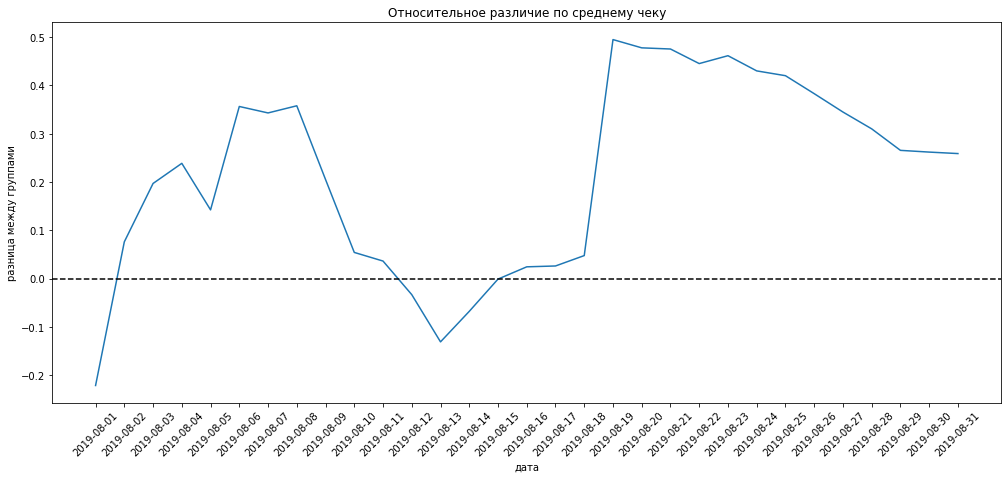

In [43]:
plt.figure(figsize=(17,7))
plt.title('Относительное различие по среднему чеку')
sns.lineplot(x='date',
             y=merged_cummulative_revenue['avg_checkB'] / merged_cummulative_revenue['avg_checkA']-1, 
             ci=None, data=merged_cummulative_revenue).set_xticklabels(merged_cummulative_revenue['date'],rotation=45)
plt.xlabel('дата')
plt.ylabel('разница между группами')
plt.axhline(y=0, color='black', linestyle='--');

В начале месяца наблюдается преимущество у группы B, однако к середине месяца с пиком 13 агуста преимущество ненадолго перехватила группа А, но затем 18 сентября произошел резкий отрыв в пользу группы B. Похоже что в этой группе были совершены дорогие покупки или чаще стали покупать.

[⬆︎ К содержанию ⬆︎](#up)

### 2.4 График кумулятивной конверсии по группам <a class='anchor' id='24'></a>

Рассчитаем кумулятивную конверсию:

In [44]:
cummulative_data['conversion'] = cummulative_data['orders'] / cummulative_data['visitors']

Построим графики кумулятивных конверсий для обеих групп:

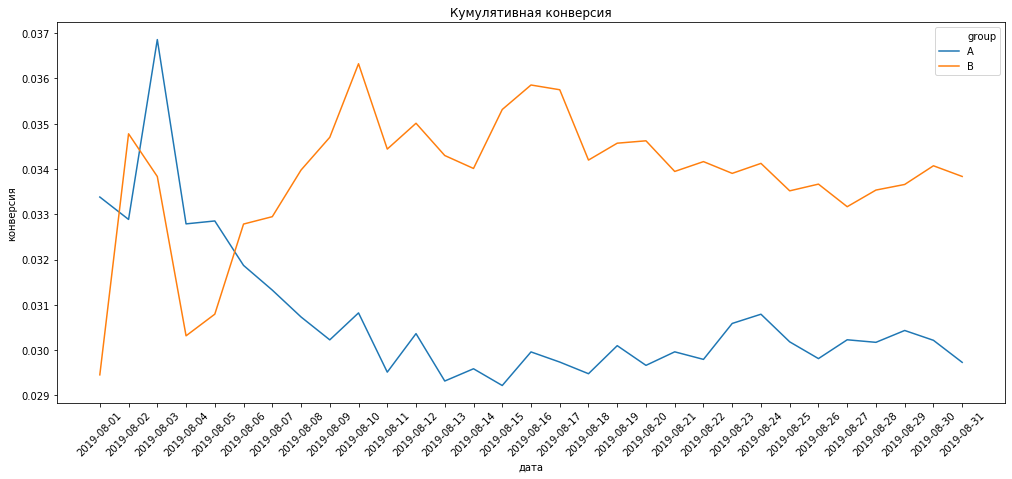

In [45]:
plt.figure(figsize=(17,7))
plt.title('Кумулятивная конверсия')
sns.lineplot(x='date', y='conversion', hue='group', data=cummulative_data).set_xticklabels(
    cummulative_data['date'].drop_duplicates(),rotation=45)
plt.xlabel('дата')
plt.ylabel('конверсия');

На данном графике видно, что в первых числах месяца конверсия была схожей, и к 4 числу новинка будто бы насторожила покупателей, но затем конверсия в группе B начала расти уверенными шагами. <a class='anchor' id='edit3'></a>

[⬆︎ К содержанию ⬆︎](#up)

### 2.5 График относительного изменения кумулятивной конверсии группы B к группе A <a class='anchor' id='25'></a>

In [46]:
merged_cummulative_conversion = cummulative_data.query('group=="A"').merge(
    cummulative_data.query('group=="B"'), on='date', how='left', suffixes=['A','B'])
merged_cummulative_conversion.head()

,date,groupA,ordersA,buyersA,revenueA,visitorsA,avg_checkA,conversionA,groupB,ordersB,buyersB,revenueB,visitorsB,avg_checkB,conversionB
0,2019-08-01,A,24,20,148579,719,6190.791667,0.033380,B,21,20,101217,713,4819.857143,0.029453
1,2019-08-02,A,44,38,242401,1338,5509.113636,0.032885,B,45,43,266748,1294,5927.733333,0.034776
2,2019-08-03,A,68,62,354874,1845,5218.735294,0.036856,B,61,59,380996,1803,6245.836066,0.033833
3,2019-08-04,A,84,77,425699,2562,5067.845238,0.032787,B,78,75,489567,2573,6276.500000,0.030315
4,2019-08-05,A,109,100,549917,3318,5045.110092,0.032851,B,101,98,581995,3280,5762.326733,0.030793


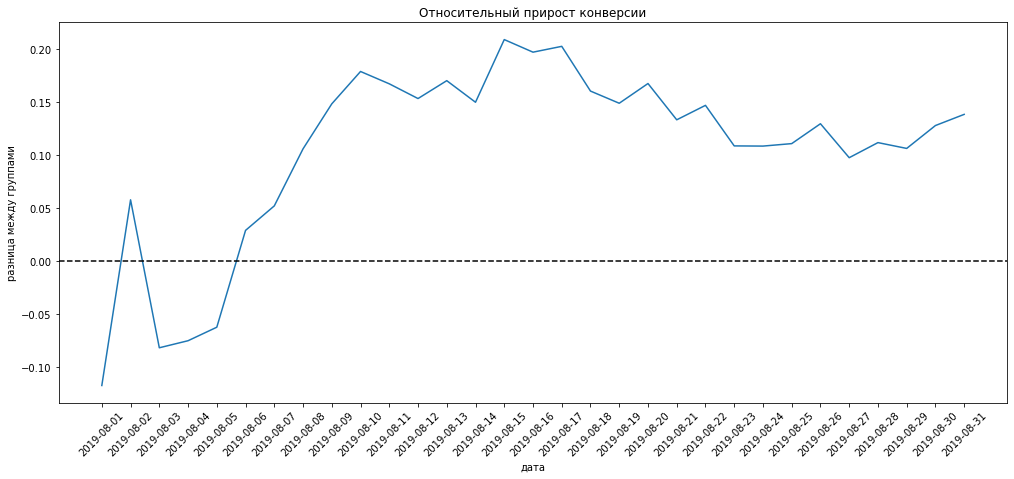

In [47]:
plt.figure(figsize=(17,7))
plt.title('Относительный прирост конверсии')
sns.lineplot(x='date',
             y=merged_cummulative_conversion['conversionB'] / merged_cummulative_conversion['conversionA']-1, 
             ci=None, data=merged_cummulative_conversion).set_xticklabels(
             merged_cummulative_conversion['date'],rotation=45)
plt.xlabel('дата')
plt.ylabel('разница между группами')
plt.axhline(y=0, color='black', linestyle='--');

В начале теста группа A имела преимущество, немного потеряв позиции на второй день и затем снова вырвалась вперед. Однако начиная с 6 августа группа начала проигрывать группе B и затем обрела абсолютное лидерство по конверсии. Что говорит о том, что в группе B стали чаще покупать.

[⬆︎ К содержанию ⬆︎](#up)

### 2.6 Точечный график количества заказов по пользователям <a class='anchor' id='26'></a>

In [48]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Подсчитаем количество заказов по пользователям:

In [49]:
orders_by_users = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitor_id', as_index=False).agg({
    'transaction_id':'nunique'})
orders_by_users.columns = ['user_id', 'orders']
orders_by_users.head()

,user_id,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


Построим точечный график:

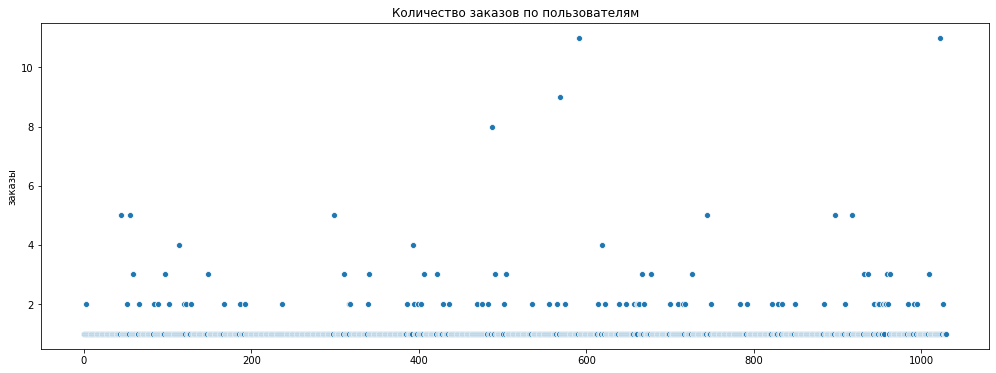

In [50]:
plt.figure(figsize=(17,6))
plt.title('Количество заказов по пользователям')
sns.scatterplot(data=orders_by_users, x=orders_by_users.index, y='orders')
plt.ylabel('заказы');

Много пользователей с 2-3 заказами. Полагаю, что аномалиями стоит считать от 4 заказов и больше.

[⬆︎ К содержанию ⬆︎](#up)

### 2.7 95-й и 99-й перцентили количества заказов на пользователя <a class='anchor' id='27'></a>

Определим перцентили:

In [51]:
orders_by_users['orders'].quantile([0.95,0.99])

0.95    2.0
0.99    4.0
Name: orders, dtype: float64

5% пользователей оформляли больше чем 2 заказа и 1% пользователей оформлял более 4х заказов. Выберем 4 заказа на одного пользователя как нижнюю границу аномалий.

[⬆︎ К содержанию ⬆︎](#up)

### 2.8 Точечный график стоимостей заказов <a class='anchor' id='28'></a>

Изучим точечный график распределения стоимости заказов:

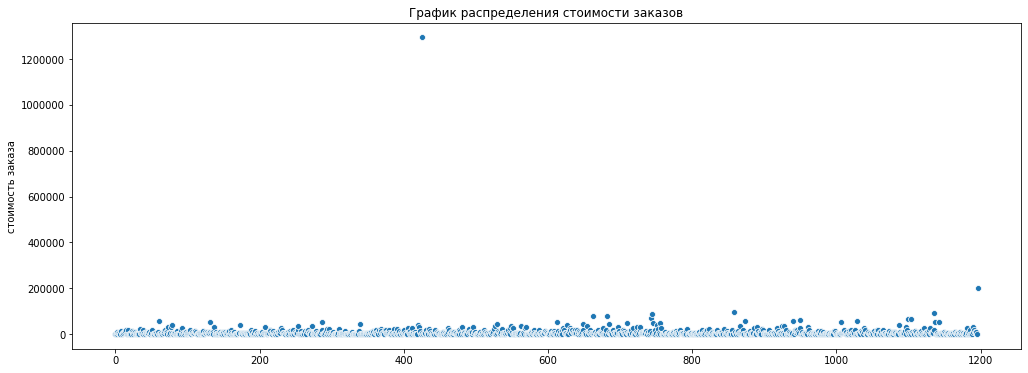

In [52]:
plt.figure(figsize=(17,6))
plt.title('График распределения стоимости заказов')
sns.scatterplot(data=orders, x=orders.index, y='revenue')
plt.ylabel('стоимость заказа');

Отмечается всего два очень дорогих заказа, один более 1200000, другой более 200000.

[⬆︎ К содержанию ⬆︎](#up)

### 2.9 95-й и 99-й перцентили стоимости заказов <a class='anchor' id='29'></a>

Определим перцентили по стоимости заказов:

In [53]:
orders['revenue'].quantile([0.95,0.99])

0.95    28000.0
0.99    58233.2
Name: revenue, dtype: float64

5% процентов покупок сделано на сумму от 28000 и 1% прокупок сделан на сумму более чем 58000.

[⬆︎ К содержанию ⬆︎](#up)

Аномальными пользователями будем считать тех, кто совершил покупки на сумму больше 28000. <a class='anchor' id='edit4'></a>

### 2.10 Статистическая значимость различий в конверсии между группами по «сырым» данным <a class='anchor' id='210'></a>

Подготовим данные...

...по посетителям:

In [54]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [55]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date','visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']
visitors_a_daily.sample(1)

,date,visitors_per_date_a
17,2019-08-18,668


In [56]:
visitors_a_cummulative = visitors_a_daily.apply(lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
    {'date':'max','visitors_per_date_a':'sum'}), axis=1)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']
visitors_a_cummulative.sample(1)

,date,visitors_cummulative_a
19,2019-08-20,12204


In [57]:
visitors_b_daily = visitors[visitors['group'] == 'B'][['date','visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']
visitors_b_daily.sample(1)

,date,visitors_per_date_b
40,2019-08-10,369


In [58]:
visitors_b_cummulative = visitors_b_daily.apply(lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
    {'date':'max','visitors_per_date_b':'sum'}), axis=1)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']
visitors_b_cummulative.sample(1)

,date,visitors_cummulative_b
32,2019-08-02,1294


...по заказам:

In [59]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [60]:
orders_a_daily = orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']].groupby(
    'date',as_index=False).agg({'transaction_id':'nunique', 'revenue':'sum'})
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']
orders_a_daily.sample(1)

,date,orders_per_date_a,revenue_per_date_a
9,2019-08-10,16,210495


In [61]:
orders_a_cummulative = orders_a_daily.apply(lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg({
    'date':'max', 'orders_per_date_a':'sum', 'revenue_per_date_a':'sum'}), axis=1).sort_values(by='date')
orders_a_cummulative.columns = ['date', 'orders_cummulative_a', 'revenue_cummulative_a']
orders_a_cummulative.sample(1)

,date,orders_cummulative_a,revenue_cummulative_a
8,2019-08-09,177,1025603


In [62]:
orders_b_daily = orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']].groupby(
    'date',as_index=False).agg({'transaction_id':'nunique', 'revenue':'sum'})
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']
orders_b_daily.sample(1)

,date,orders_per_date_b,revenue_per_date_b
8,2019-08-09,25,160812


In [63]:
orders_b_cummulative = orders_b_daily.apply(lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg({
    'date':'max', 'orders_per_date_b':'sum', 'revenue_per_date_b':'sum'}), axis=1).sort_values(by='date')
orders_b_cummulative.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b']
orders_b_cummulative.sample(1)

,date,orders_cummulative_b,revenue_cummulative_b
17,2019-08-18,382,2686621


Объедим все полученные датафреймы в единый датафрейм:

In [64]:
ab = (
    orders_a_daily.merge(orders_b_daily, on='date', how='left')
    .merge(orders_a_cummulative, on='date', how='left')
    .merge(orders_b_cummulative, on='date', how='left')
    .merge(visitors_a_daily, on='date', how='left')
    .merge(visitors_b_daily, on='date', how='left')
    .merge(visitors_a_cummulative, on='date', how='left')
    .merge(visitors_b_cummulative, on='date', how='left')
)
ab.head()

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Для рассчета статистической значимости создадим списки с пользователями для обеих групп:

In [65]:
orders_by_users_a = orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg(
    {'transaction_id': 'nunique'})
orders_by_users_a.columns = ['user_id', 'orders']
orders_by_users_a.head(5)

,user_id,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [66]:
orders_by_users_b = orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg(
    {'transaction_id': 'nunique'})
orders_by_users_b.columns = ['user_id', 'orders']
orders_by_users_b.head(5)

,user_id,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


Создадим массивы sample_a и sample_b и поместим в них количество заказов:

In [67]:
sample_a = pd.concat(
    [orders_by_users_a['orders'], pd.Series(0, 
                                            index=np.arange(ab['visitors_per_date_a'].sum() - len(
                                            orders_by_users_a['orders'])),name='orders')], axis=0)

In [68]:
sample_b = pd.concat(
    [orders_by_users_b['orders'], pd.Series(0, 
                                            index=np.arange(ab['visitors_per_date_b'].sum() - len(
                                            orders_by_users_b['orders'])),name='orders')], axis=0)

Cформулируем нулеву гипотезу: <a class='anchor' id='edit5'></a>

---
*$H_0=$ "
Конверсия по "сырым" данным в группе А не отличается от конверсии по "сырым" данным в группе B"*

---

Произведем проверку критерем Манна-Уитни (это непараметрический метод, который наиболее уместен; когда существует большое количество выбросов, алгебраические методы могут быть сильно искажены):

In [69]:
st.mannwhitneyu(sample_a, sample_b)[1].round(4)

0.0084

Статистическая значимость ниже 0.05, что говорит нам о вероятном различии в конверсиях по "сырым" данным между группами. Нулевую гипотезу на данном этапе отвергаем.

In [70]:
round((sample_b.mean() / sample_a.mean()-1),4)

0.1381

Относительное преимущество группы B равняется 13,81%.

[⬆︎ К содержанию ⬆︎](#up)

### 2.11 Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным <a class='anchor' id='211'></a>

Cформулируем нулеву гипотезу: <a class='anchor' id='edit6'></a>

---
*$H_0=$ "Средний чек по "сырым" данным в группе А не отличается от среднего чека по "сырым" данным в группе B"*

---

Определим статистическую значимость критерем Манна-Уитни (метод уместен когда существует большое количество выбросов - алгебраические методы могут быть сильно искажены):

In [71]:
st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'],orders[orders['group'] == 'B']['revenue'])[1].round(4)

0.3646

Значение статистической значимости выше 0.05, это говорит о том, что отвергнуть нулевую гипотезу не получилось. Высокая вероятность, что в среднем чеке различия отсутствуют.

In [72]:
round((orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean()-1),4)

0.2587

Средний чек группы B на 25.85% выше чем у группы А.

[⬆︎ К содержанию ⬆︎](#up)

### 2.12 Статистическая значимость различий в конверсии между группами по «очищенным» данным <a class='anchor' id='212'></a>

Выделим аномальных пользователей по заказам (отсечем 1% - более 4 покупок):

In [73]:
users_with_many_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > 4]['user_id'],
                                   orders_by_users_b[orders_by_users_b['orders'] > 4]['user_id']], axis=0)

Выделим аномальных пользователей по стоимости (отсечем 5% - стоимость заказа более 28000):

In [74]:
users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitor_id']

Объединим пользователей в датафрейм с аномальными пользователями:

In [75]:
abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], 
                           axis=0).drop_duplicates().sort_values()
abnormal_users.shape

(59,)

- Мы получили 59 аномальных пользователей.

Отфильтруем пользователей и сделаем данные "очищенными":

In [76]:
sample_a_filtered = pd.concat([orders_by_users_a[~(orders_by_users_a['user_id'].isin(abnormal_users))]['orders'],
                              pd.Series(0, index=np.arange(ab['visitors_per_date_a'].sum() - 
                                                          len(orders_by_users_a['orders'])), name='orders')], axis=0)
sample_b_filtered = pd.concat([orders_by_users_b[~(orders_by_users_b['user_id'].isin(abnormal_users))]['orders'],
                              pd.Series(0, index=np.arange(ab['visitors_per_date_b'].sum() - 
                                                          len(orders_by_users_b['orders'])), name='orders')], axis=0)

Проверим распределение "очищенных" данных на нормальность распределения: <a class='anchor' id='edit7'></a>

In [77]:
sample_a_filtered.describe()

count    18703.000000
mean         0.027054
std          0.177663
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: orders, dtype: float64

In [78]:
sample_b_filtered.describe()

count    18879.000000
mean         0.030987
std          0.186820
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: orders, dtype: float64

---
*$H_0=$ "
Конверсия по "очищенным" данным в группе А не отличается от конверсии в группе B"*

---

Вычислим статистическую значимость, используя критерий Манна-Уитни (поскольку "очищенные" данные нормально не распределены, алгебраические методы дадут искаженные результаты):

In [79]:
st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1].round(4)

0.0092

Полученная статистическая значимость меньше 0.05 - нулевую гипотезу отвергаем. Вероятность сходства выборок слишком мала, чтобы с уверенностью утверждать, что разница в конверсиях между группами не значительна.

In [80]:
round((sample_b_filtered.mean() / sample_a_filtered.mean()-1),4)

0.1453

Группа B опережает по конверсии группу А на 14,53%.

[⬆︎ К содержанию ⬆︎](#up)

### 2.13 Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным <a class='anchor' id='213'></a>

Исследуем распределние "очищенных" данных: <a class='anchor' id='edit8'></a>

In [81]:
orders[(orders['group'] == 'A') & (~orders['visitor_id'].isin(abnormal_users))]['revenue'].describe()

count      506.000000
mean      5140.804348
std       5799.177280
min         50.000000
25%       1090.000000
50%       2720.000000
75%       6754.250000
max      27550.000000
Name: revenue, dtype: float64

In [82]:
orders[(orders['group'] == 'B') & (~orders['visitor_id'].isin(abnormal_users))]['revenue'].describe()

count      585.000000
mean      5069.731624
std       5779.542931
min         50.000000
25%       1190.000000
50%       2690.000000
75%       6613.000000
max      27985.000000
Name: revenue, dtype: float64

Распределение даннных по "очищенным заказам" не нормально.

Сформулируем нулевую гипотезу:

---
*$H_0=$ "Средний чек по "очищенным" данным в группе А не отличается от среднего чека в группе B"*

---

Произведем вычисление статистической значимости между группами по среднему чеку методом Манна-Уитни (так как алгебрраические методы могут быть вновь искажены):

In [83]:
st.mannwhitneyu(orders[(orders['group'] == 'A') & (~orders['visitor_id'].isin(abnormal_users))]['revenue'],
            orders[(orders['group'] == 'B') & (~orders['visitor_id'].isin(abnormal_users))]['revenue'])[1].round(4)

0.4806

Статистическая значимость выше порога в 0.05, что не дает нам отвергнуть нулевую гипотезу. Большая вероятность что результаты по среднему чеку не различаются.

In [84]:
round((
    orders[(orders['group'] == 'B') & (~orders['visitor_id'].isin(abnormal_users))]['revenue'].mean() /
    orders[(orders['group'] == 'A') & (~orders['visitor_id'].isin(abnormal_users))]['revenue'].mean()-1
),4)

-0.0138

Группа B проигрывает группе А по среднему чеку 1,38%.

[⬆︎ К содержанию ⬆︎](#up)

### 2.14 Решение по результатам теста <a class='anchor' id='214'></a>

Результаты тестирования:

По конверсии:

- Статистическая значимость **ниже** 0.05, что говорит нам о вероятном различии в конверсиях по "сырым" данным между группами. Нулевую гипотезу на данном этапе **отвергаем**.

- Относительное **преимущество группы B** по конверсии, исходя из "сырых" данных, равняется 13,81%.


- Полученная на "очищенных" данных статистическая значимость **ниже** 0.05 - нулевую гипотезу **отвергаем**. Вероятность сходства выборот слишком мала, чтобы с уверенностью утверждать, что изменения не значительны.

- "Очищенные" данные показывают, что **группа B опережает по конверсии** группу А на 14,53%.

По среднему чеку:

- Значение статистической значимости по "сырым" данным **выше** 0.05, это говорит о том, что отвергнуть **нулевую гипотезу** не получилось. Высокая вероятность, что в среднем чеке различия отсутствуют.

- "Сырые" данные показали, что **средний чек группы B** на 25.85% **выше** чем у группы А.


- Статистическая значимость по "очищенным" данным **выше** порога в 0.05, что не дает нам отвергнуть **нулевую гипотезу**. Большая вероятность что результаты по среднему чеку не различаются.

- "Очищенные" данные показывают, что группа B **проигрывает** группе А по среднему чеку 1,38%.

##### Выводы:

- Между группами существует статистически значимое различие как по "сырым" данным так и после фильтрации аномалий.

- Между группами не существует статистически значимого различия по среднему чеку ни по "сырым", ни под отфильтрованным данным.

- График различия конверсий показывает позитивные тенденции для группы B.

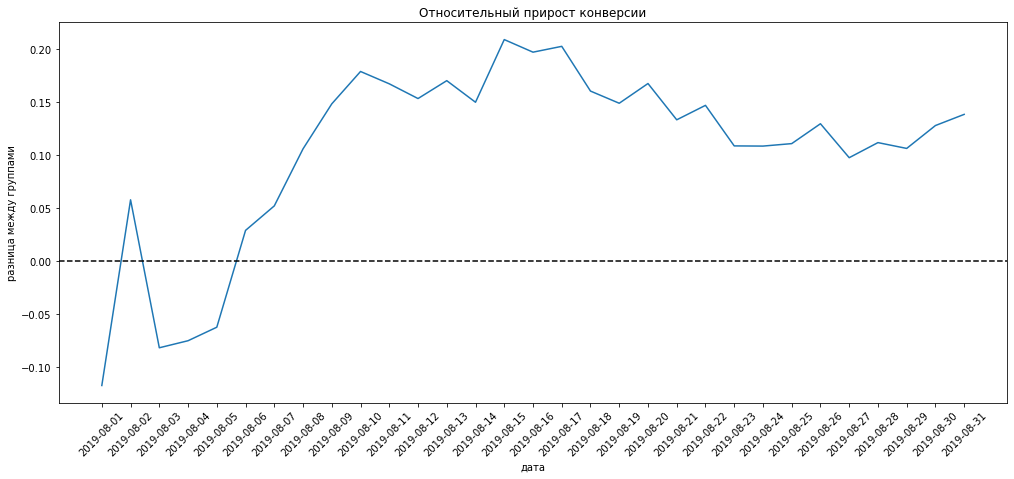

- График различия по среднему чеку показывает относительное преимущество группы B. Однако тенденция не постоянна. Однозначеные выводы из графика сделать сложно.

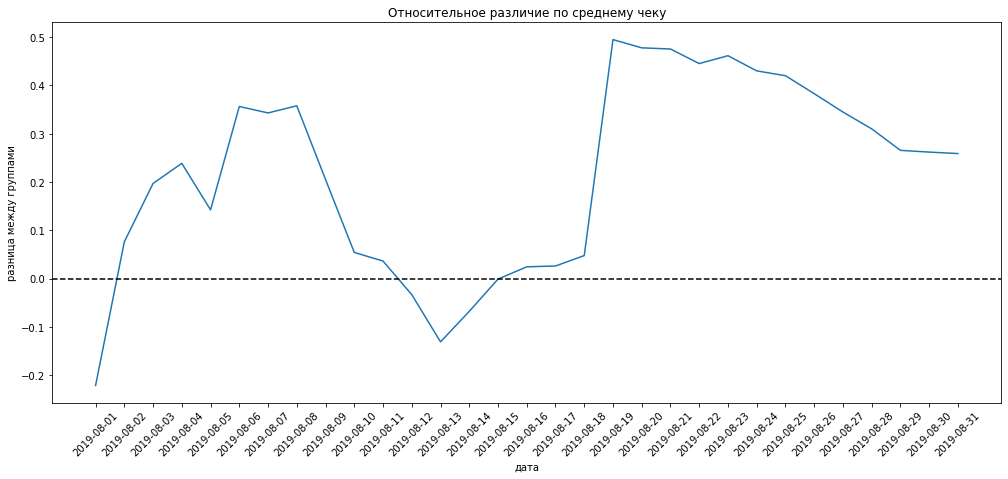

---
*ЗАКЛЮЧЕНИЕ*: **Остановить тест и признать победу группы B. Изменения группы B позитивно сказались на конверсии.** <a class='anchor' id='total'></a>

---

[⬆︎ К содержанию ⬆︎](#up)